In [20]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from __future__ import division
import sklearn.linear_model as linear_model

#Loading the training and the test data
Train_df = pd.read_csv('C:/Users/Mash/Desktop/Kaggle/Regression_house_prices/train.csv')
Test_df = pd.read_csv('C:/Users/Mash/Desktop/Kaggle/Regression_house_prices/test.csv')

#print (Train_df.columns)
#print (Train_df.describe())

# No of columns in the df
#print (Train_df.info())

#Segregating Quantitative and Qualitative columns
quantitative = [f for f in Train_df.columns if Train_df.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in Train_df.columns if Train_df.dtypes[f] == 'object']

# checking the columns with NaN values
NaN_columns = {}
for i in Train_df.columns:
    if pd.isnull(Train_df[i]).sum() >0:
        NaN_columns[i] = pd.isnull(Train_df[i]).sum()
print (NaN_columns)




{'Electrical': 1, 'MasVnrType': 8, 'MiscFeature': 1406, 'BsmtExposure': 38, 'BsmtQual': 37, 'Fence': 1179, 'BsmtCond': 37, 'GarageCond': 81, 'GarageYrBlt': 81, 'LotFrontage': 259, 'BsmtFinType2': 38, 'GarageFinish': 81, 'BsmtFinType1': 37, 'GarageQual': 81, 'GarageType': 81, 'MasVnrArea': 8, 'FireplaceQu': 690, 'Alley': 1369, 'PoolQC': 1453}


1456


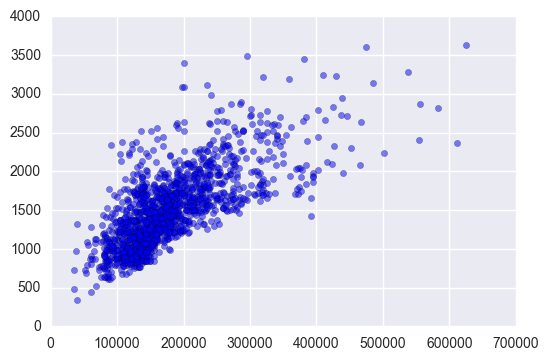

In [25]:
# plotting Sale Price versus GR Living Area
Train_df = Train_df[Train_df.GrLivArea < 4000]
plt.scatter(Train_df.SalePrice,Train_df.GrLivArea,alpha = 0.5)
print (len(Train_df))


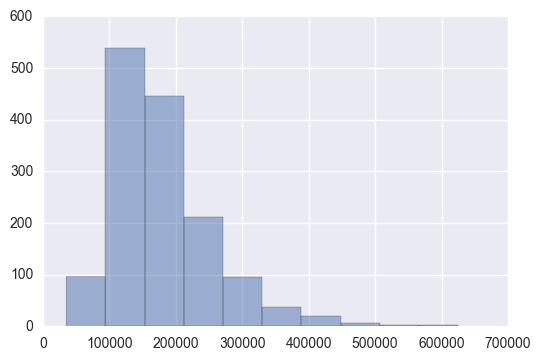

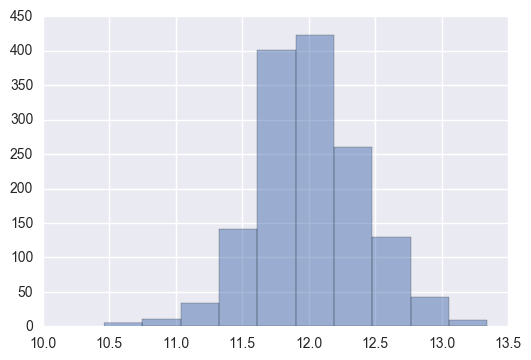

In [26]:
#Analysing the sale price normality and applying log transformation since the original values are right skewed
plt.hist(Train_df['SalePrice'], alpha = 0.5)
plt.show()
y =np.log(Train_df['SalePrice'])
plt.hist(y,alpha = 0.5)
plt.show()


In [28]:
#Checking for Duplicate Id's
Train_df = Train_df.drop_duplicates(subset = 'Id')
print (len(Train_df))

#No duplicate Ids found
#https://ww2.amstat.org/publications/jse/v19n3/decock.pdf




1456


In [29]:
# Treatment of Nan Values in Quantitative data
for i in quantitative:
    if i in NaN_columns:
        print (i)

#LotFrontage/MasVnrArea/GarageYrBlt
# If Na is there in LotFrontage then no area is present
Train_df['LotFrontage'] = Train_df['LotFrontage'].fillna(0)

# MasVnrArea is Nan means there is no veneer area in the house
Train_df['MasVnrArea'] = Train_df['MasVnrArea'].fillna(0)

# If GarageYrBlt has Nan most likely no garage in the house but again it is a discrete variable
Train_df['GarageYrBlt']=Train_df['GarageYrBlt'].fillna('MISSING')

LotFrontage
MasVnrArea
GarageYrBlt


In [30]:
# Checking the Quanlitative variable and adding a category MISSING if Nan is present
for i in qualitative:
    if i in NaN_columns:
        print (i)


Alley
MasVnrType
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Electrical
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PoolQC
Fence
MiscFeature


In [31]:
# For all the above except Electrical -
#NA means the feature is not available in the house and hence can be safely substituted as missing
qualitative.remove('Electrical')
for i in qualitative:
    if Train_df[i].isnull().any():
        Train_df[i]=Train_df[i].fillna('MISSING')
qualitative.append('Electrical')     
Train_df['Electrical'] = Train_df['Electrical'].fillna('FuseA') # filling the average value



(43, 2)
(41, 2)


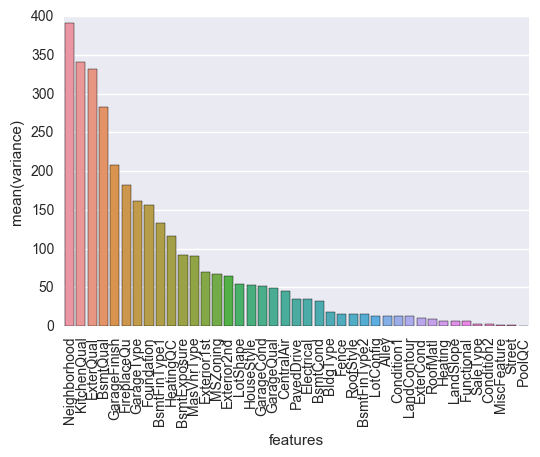

In [24]:
#Grouping the categorical variables to check the ANOVA
#If the P value is less among them ,then they have low impact on the sale price else high impact

def anova(train):
    anova_df = pd.DataFrame({'features':qualitative})
    pvals = []
    for i in qualitative:
        values =[]
        for j in train[i].unique():
            SP = train[train[i]==j]['SalePrice'].values
            values.append(SP)
        #print (*values)
        pval = stats.f_oneway(*values)[1]
        pvals.append(pval)
    anova_df['pvals'] = pvals
    return anova_df.sort_values('pvals')        
a = anova(Train_df)
print (a.shape)
a = a[a.pvals.notnull()]
print (a.shape)
a['variance'] = np.log(1/a['pvals'].values)
sns.barplot(data = a, x = 'features', y = 'variance')
x=plt.xticks(rotation=90) #[ for making the features visible]

In [28]:
# from the above only the variables with non null P value to be considered for further operations
qualitative_reduced =a.features
print (qualitative_reduced)

8     Neighborhood
30     KitchenQual
18       ExterQual
21        BsmtQual
34    GarageFinish
32     FireplaceQu
33      GarageType
20      Foundation
24    BsmtFinType1
27       HeatingQC
23    BsmtExposure
17      MasVnrType
15     Exterior1st
0         MSZoning
16     Exterior2nd
3         LotShape
12      HouseStyle
36      GarageCond
35      GarageQual
28      CentralAir
37      PavedDrive
29      Electrical
22        BsmtCond
11        BldgType
39           Fence
13       RoofStyle
25    BsmtFinType2
6        LotConfig
2            Alley
9       Condition1
4      LandContour
19       ExterCond
14        RoofMatl
26         Heating
7        LandSlope
31      Functional
41        SaleType
10      Condition2
40     MiscFeature
1           Street
38          PoolQC
Name: features, dtype: object


In [18]:
# Working on ordinal variables and simplifying them
Train_df["SimplOverallQual"] = Train_df.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
Train_df["SimplOverallCond"] = Train_df.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
#Encoding ordinal features into numbers
# Encode some categorical features as ordered numbers when there is information in the order
Train_df = Train_df.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"MISSING" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"MISSSING" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"MISSING" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"MISSING" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"MISSSING" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"MISSING" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"MISSING" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"MISSING" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"MISSING" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

In [ ]:
#Combining features
#doubling  weightage to the fact that there is a presence of Lot frontage
Train_df['LotScore']= (Train_df[LotFrontage]*2 +Train_df[LotArea])*LotShape

#Overall score for the house 
Train_df['OverallScore']=Train_df['OverallCond']*Train_df['OverallQual']

#Garage Score
Train_df["GarageScore"] = Train_df["GarageQual"] * Train_df["GarageCond"]

#External score
Train_df["ExterScore"] = Train_df["ExterQual"] * Train_df["ExterCond"]

#Basement Score
Train_df["BaseScore"] = Train_df["BaseQual"] * Train_df["BaseCond"]

#PoolScore
Train_df["PoolScore"] = Train_df["PoolArea"] * Train_df["PoolQC"]

#KitchenScore (since more number of kitchens need not proportionately affect the score.In general it is 1)
Train_df["KitchenScore"] = Train_df["KitchenAbvGr"] * 0.6 *Train_df["KitchenQual"]

#Fireplace Score
Train_df["FireScore"] = Train_df["Fireplaces"] * Train_df["FireplaceQu"]

#Total Porch and Deck
Train_df["PorchDeck"] = Train_df["OpenPorchSF"] + Train_df["EnclosedPorch"] +\
Train_df["3SsnPorch"] + Train_df["ScreenPorch"]+Train_df['WoodDeckSF']

# Total number of bathrooms
Train_df["TotalBath"] = Train_df["BsmtFullBath"] + (0.5 * Train_df["BsmtHalfBath"]) + \
Train_df["FullBath"] + (0.5 * Train_df["HalfBath"])

#Total SquareFoot
Train_df["AllSF"] = Train_df["GrLivArea"] + Train_df["TotalBsmtSF"]+Train_df["1stFlrSF"] + Train_df["2ndFlrSF"]

# Has masonry veneer or not
Train_df["HasMasVnr"] = Train_df.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                               "Stone" : 1, "None" : 0})

Train_df["BoughtOffPlan"] = Train_df.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})

#House Age at the time of sale
Train_df['HouseAge'] =  Train_df['YrSold']-Train_df['YearBuilt'] 
Train_df['RemodelAge'] = Train_df['YrSold']-Train_df['YearRemodAdd']
Train_df['HouseScore'] = Train_df['HouseAge'] * (Train_df['RemodelAge']*0.5)

